# Visual-language assistant with Pixtral and OpenVINO

Pixtral-12b is multimodal model that consists of 12B parameter multimodal decoder based on Mistral Nemo and 400M parameter vision encoder trained from scratch. It is trained to understand both natural images and documents. The model shows strong abilities in tasks such as chart and figure understanding, document question answering, multimodal reasoning and instruction following. Pixtral is able to ingest images at their natural resolution and aspect ratio, giving the user flexibility on the number of tokens used to process an image. Pixtral is also able to process any number of images in its long context window of 128K tokens. Unlike previous open-source models, Pixtral does not compromise on text benchmark performance to excel in multimodal tasks.

![](https://mistral.ai/images/news/pixtral-12b/pixtral-model-architecture.png)


More details about model are available in [blog post](https://mistral.ai/news/pixtral-12b/) and [model card](https://huggingface.co/mistralai/Pixtral-12B-2409)

In this tutorial we consider how to convert, optimize and run this model using OpenVINO.

<div class="alert alert-block alert-warning"> <b>Important note</b>: Please take into account that pixtral is large model. Its conversion requires at least 50GB disk space available</div>

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert and Optimize model](#Convert-and-Optimize-model)
- [Run model inference](#Run-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Initialize inference pipeline](#Initialize-inference-pipeline)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/pixtral/pixtral.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "torch>=2.1" torchvision "pillow" "tqdm" "gradio>=4.36"  --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"  --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "nncf>=2.13.0" "openvino>=2024.4"
%pip install -q "transformers>=4.45.0"  --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
from pathlib import Path
import requests

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/refs/heads/latest/notebooks/pixtral/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

## Convert and Optimize model
[back to top ⬆️](#Table-of-contents:)

For convenience, we will use OpenVINO integration with HuggingFace Optimum. 🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Among other use cases, Optimum Intel provides a simple interface to optimize your Transformers and Diffusers models, convert them to the OpenVINO Intermediate Representation (IR) format and run inference using OpenVINO Runtime. `optimum-cli` provides command line interface for model conversion and optimization. 

General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager). Additionally, you can specify weights compression using `--weight-format` argument with one of following options: `fp32`, `fp16`, `int8` and `int4`. Fro int8 and int4 [nncf](https://github.com/openvinotoolkit/nncf) will be used for  weight compression. More details about model export provided in [Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/openvino/export#export-your-model).

In [3]:
import ipywidgets as widgets

model_base_dir = Path("pixtral-12b")

precisions = ["FP16", "INT8", "INT4"]

precision_selector = widgets.Dropdown(description="compression", options=precisions, value=precisions[-1])

precision_selector

Dropdown(description='compression', index=2, options=('FP16', 'INT8', 'INT4'), value='INT4')

In [4]:
model_dir = model_base_dir / precision_selector.value

if not (model_dir / "openvino_language_model.xml").exists():
    !optimum-cli export openvino -m "mistral-community/pixtral-12b" --weight-format {precision_selector.value.lower()} {model_dir}

## Run model inference
[back to top ⬆️](#Table-of-contents:)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

In [5]:
from notebook_utils import device_widget

device = device_widget(default="CPU", exclude=["NPU"])

device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

### Initialize inference pipeline
[back to top ⬆️](#Table-of-contents:)

OpenVINO integration with Optimum Intel provides ready-to-use API for model inference that can be used for smooth integration with transformers-based solutions. For loading pixtral model, we will use `OVModelForVisualCausalLM` class that have compatible interface with Transformers Pixtral implementation. For loading a model, `from_pretrained` method should be used. It accepts path to the model directory or model_id from HuggingFace hub (if model is not converted to OpenVINO format, conversion will be triggered automatically). Additionally, we can provide an inference device, quantization config (if model has not been quantized yet) and device-specific OpenVINO Runtime configuration. More details about model inference with Optimum Intel can be found in [documentation](https://huggingface.co/docs/optimum/intel/openvino/inference). 

In [6]:
from transformers import AutoProcessor
from optimum.intel.openvino import OVModelForVisualCausalLM

processor = AutoProcessor.from_pretrained(model_dir)
ov_model = OVModelForVisualCausalLM.from_pretrained(model_dir, device=device.value)

2024-10-02 18:03:58.850094: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 18:03:58.851883: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 18:03:58.888025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 18:03:59.657376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Compiling the Language model to CPU ...
Compiling the Text embeddings model to CPU ...
Compiling the vision_embedd

Question: What is unusual on this image?


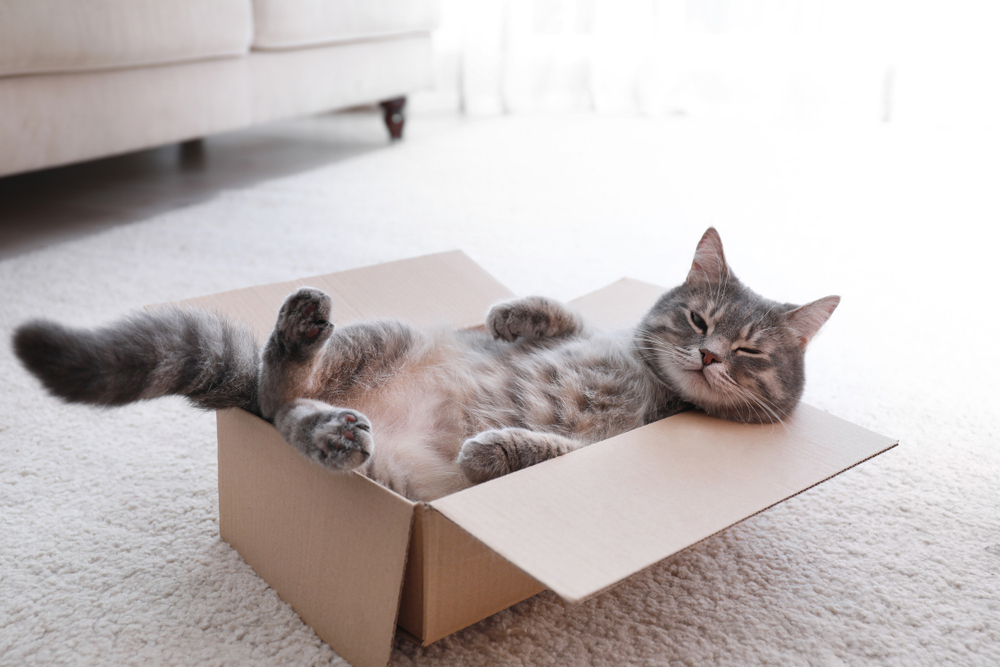

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


The unusual aspect of this image is the presence of a cat and a dog lying together peacefully inside a cardboard box. This is not a common sight, as cats and dogs are often perceived as being natural enemies or at least not inclined to share spaces closely. The image portrays a harmonious and playful interaction between the two animals, which challenges typical stereotypes about their relationship.


In [7]:
from PIL import Image
from transformers import TextStreamer
from gradio_helper import chat_template, resize_with_aspect_ratio

if processor.chat_template is None:
    processor.set_chat_template(chat_template)

question = "What is unusual on this image?"

messages = [
    {"role": "user", "content": [{"type": "text", "content": question}, {"type": "image"}]},
]
text = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/d5fbbd1a-d484-415c-88cb-9986625b7b11"
raw_image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=text, images=[resize_with_aspect_ratio(raw_image)], return_tensors="pt")
streamer = TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True)
print(f"Question: {question}")
display(raw_image)
output = ov_model.generate(**inputs, do_sample=False, max_new_tokens=100, temperature=None, top_p=None, streamer=streamer)

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_model, processor)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/